# Xgboost Feature

In [1]:
import pandas as pd
import xgboost as xgb
import numpy as np
import seaborn as sns

from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor, BaggingRegressor

%matplotlib inline

/Users/ruizhang/anaconda3/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
train = pd.read_csv('bike.csv')

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
datetime      10886 non-null object
season        10886 non-null int64
holiday       10886 non-null int64
workingday    10886 non-null int64
weather       10886 non-null int64
temp          10886 non-null float64
atemp         10886 non-null float64
humidity      10886 non-null int64
windspeed     10886 non-null float64
casual        10886 non-null int64
registered    10886 non-null int64
count         10886 non-null int64
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.6+ KB


There're **10 886** observations and **12** features.

### High level
1. There are no missing values.
2. Most values are integers, few of them floats and only one an object (should be a date).
3. season, weather are categorical variables (contains for possible values - 1, 2, 3, 4)


### More detailed
1. **datetime** - hourly date + timestamp
2. **season** -  
    1 = spring  
    2 = summer  
    3 = fall  
    4 = winter  
3. **holiday** - whether the day is considered a holiday
4. **workingday** - whether the day is neither a weekend nor holiday
5. **weather** -   
    1: Clear, Few clouds, Partly cloudy, Partly cloudy   
    2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist  
    3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds  
    4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog  
6. **temp** - temperature in Celsius
7. **atemp** - "feels like" temperature in Celsius
8. **humidity** - relative humidity
9. **windspeed** - wind speed
10. **casual** - number of non-registered user rentals initiated
11. **registered** - number of registered user rentals initiated
12. **count** - number of total rentals



## Target variable¶

The goal is predict - **count**
Note: **count** = **registered** + **casual**

## Quality function

$$ \sqrt{\frac{1}{n} \sum_{i=1}^n (\ln(p_i + 1) - \ln(a_i+1))^2 }$$

where  
**n** is the number of hours in the test set  
**pi** is your predicted count  
**ai** is the actual count  
**ln(x)** is the natural logarithm  

## Simple Feature Engineering
Let's extract day in separeted column (is needed for validation as well)

In [4]:
train['datetime'] = pd.to_datetime( train['datetime'] )
train['day'] = train['datetime'].map(lambda x: x.day)

## Modeling

In [5]:
def assing_test_samples(data, last_training_day=0.3, seed=1):
    days = data.day.unique()
    np.random.seed(seed)
    np.random.shuffle(days)
    test_days = days[: int(len(days) * 0.3)]
    
    data['is_test'] = data.day.isin(test_days)


def select_features(data):
    columns = data.columns[ (data.dtypes == np.int64) | (data.dtypes == np.float64) | (data.dtypes == np.bool) ].values    
    return [feat for feat in columns if feat not in ['count', 'casual', 'registered'] and 'log' not in feat ] 

def get_X_y(data, target_variable):
    features = select_features(data)
        
    X = data[features].values
    y = data[target_variable].values
    
    return X,y

def train_test_split(train, target_variable):
    df_train = train[train.is_test == False]
    df_test  = train[train.is_test == True]
    
    X_train, y_train = get_X_y(df_train, target_variable)
    X_test, y_test = get_X_y(df_test, target_variable)
    
    return X_train, X_test, y_train, y_test



def fit_and_predict(train, model, target_variable):
    X_train, X_test, y_train, y_test = train_test_split(train, target_variable)
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    return (y_test, y_pred)

def post_pred(y_pred):
    y_pred[y_pred < 0] = 0
    return y_pred

def rmsle(y_true, y_pred, y_pred_only_positive=True):
    if y_pred_only_positive: y_pred = post_pred(y_pred)
        
    diff = np.log(y_pred+1) - np.log(y_true+1)
    mean_error = np.square(diff).mean()
    return np.sqrt(mean_error)

##########

def count_prediction(train, model, target_variable='count'):
    (y_test, y_pred) = fit_and_predict(train, model, target_variable)

    if target_variable == 'count_log': 
        y_test = train[train.is_test == True]['count']
        y_pred = np.exp2(y_pred)
        
    return rmsle(y_test, y_pred)

    
def registered_casual_prediction(train, model):
    (_, registered_pred) = fit_and_predict(train, model, 'registered')
    (_, casual_pred) = fit_and_predict(train, model, 'casual')

    y_test = train[train.is_test == True]['count']
    y_pred = registered_pred + casual_pred
    
    return rmsle(y_test, y_pred)

def log_registered_casual_prediction(train, model):
    (_, registered_pred) = fit_and_predict(train, model, 'registered_log')
    (_, casual_pred) = fit_and_predict(train, model, 'casual_log')
   
    y_test = train[train.is_test == True]['count']
    y_pred = (np.exp2(registered_pred) - 1) + (np.exp2(casual_pred) -1)
    
    return rmsle(y_test, y_pred)
    
##########

def importance_features(model, data):
    impdf = []
    fscore = model.booster().get_fscore()
    maps_name = dict([ ("f{0}".format(i), col) for i, col in enumerate(data.columns)])

    for ft, score in fscore.iteritems():
        impdf.append({'feature': maps_name[ft], 'importance': score})
    impdf = pd.DataFrame(impdf)
    impdf = impdf.sort_values(by='importance', ascending=False).reset_index(drop=True)
    impdf['importance'] /= impdf['importance'].sum()
    impdf.index = impdf['feature']
        
    return impdf  

def draw_importance_features(model, train):
    impdf = importance_features(model, train)
    return impdf.plot(kind='bar', title='Importance Features', figsize=(20, 8))
    
    
assing_test_samples(train)

## Dummy Regressor
The most simple one :)

In [6]:
print('dummy', count_prediction(train, DummyRegressor()))
print('xgboost', count_prediction(train, xgb.XGBRegressor()))

('dummy', 1.5758678110942455)
('xgboost', 1.3222047419868168)


## Feature engineering

Let's a bit improve quality

In [7]:
def etl_datetime(df):
    df['year'] = df['datetime'].map(lambda x: x.year)
    df['month'] = df['datetime'].map(lambda x: x.month)

    df['hour'] = df['datetime'].map(lambda x: x.hour)
    df['minute'] = df['datetime'].map(lambda x: x.minute)
    df['dayofweek'] = df['datetime'].map(lambda x: x.dayofweek)
    df['weekend'] = df['datetime'].map(lambda x: x.dayofweek in [5,6])

    
etl_datetime(train)

('xgboost', 0.71226527946687523)


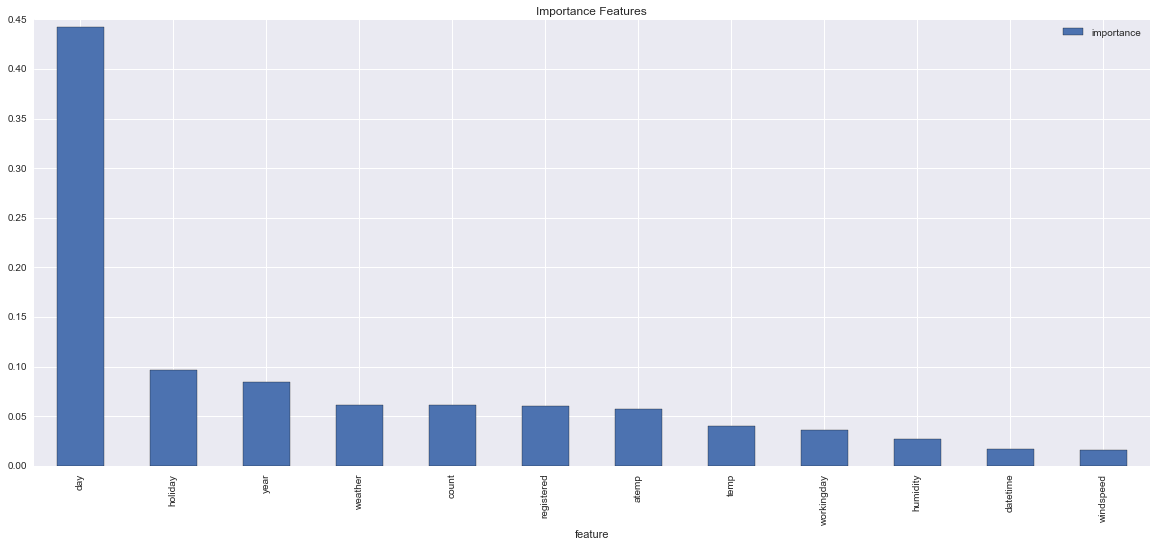

In [8]:
model = xgb.XGBRegressor()
print('xgboost', count_prediction(train, model))
draw_importance_features(model, train)

## Predict count = register + casual

('xgboost', 0.73669841949326831)


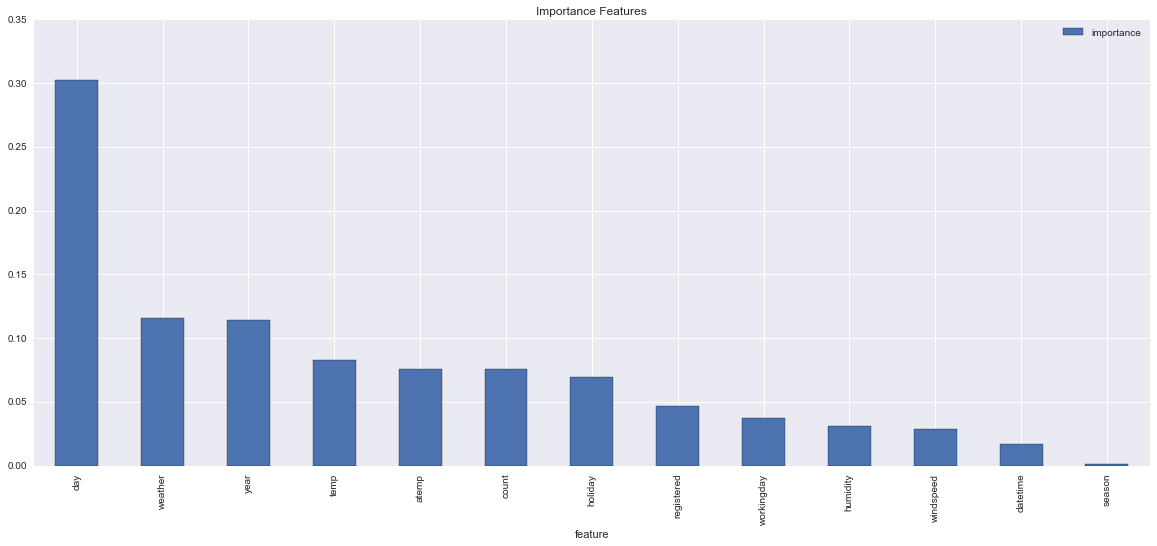

In [9]:
model = xgb.XGBRegressor()
print('xgboost', registered_casual_prediction(train, model))
draw_importance_features(model, train)

## Logarithm combination - count_log, registered_log, casual_log

In [10]:
train['{0}_log'.format('count')] = train['count'].map(lambda x: np.log2(x) )

for name in ['registered', 'casual']:
    train['{0}_log'.format(name)] = train[name].map(lambda x: np.log2(x+1) )

### Predict count = exp(count_log)

('xgboost', 0.41322977213972051)


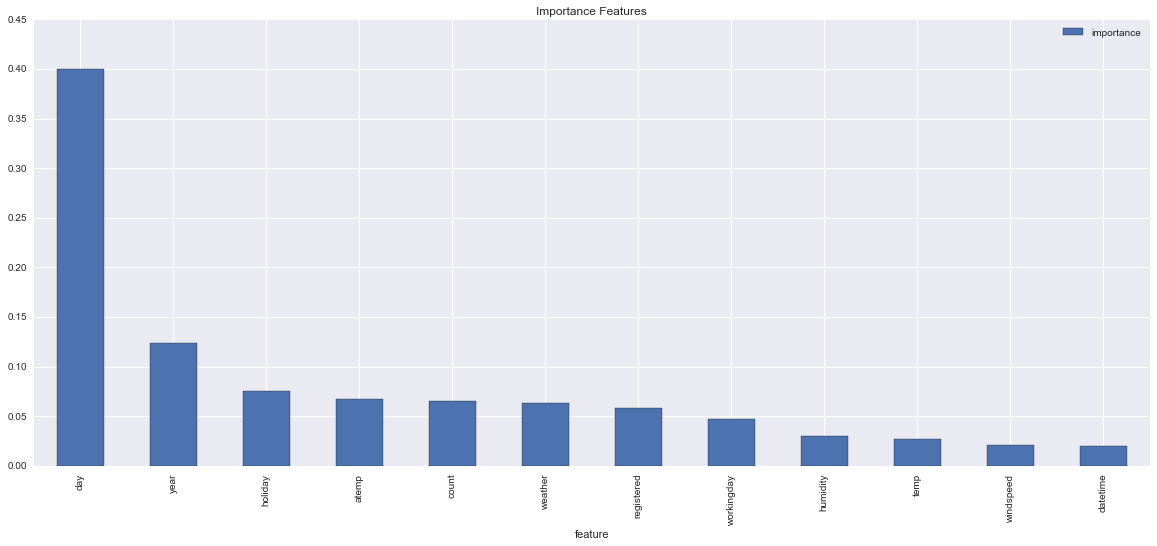

In [11]:
model = xgb.XGBRegressor()
print('xgboost', count_prediction(train, model, 'count_log'))
draw_importance_features(model, train)

### Predict count = exp(registered_log) + exp(casual_log)

('xgboost', 0.39339177031871342)


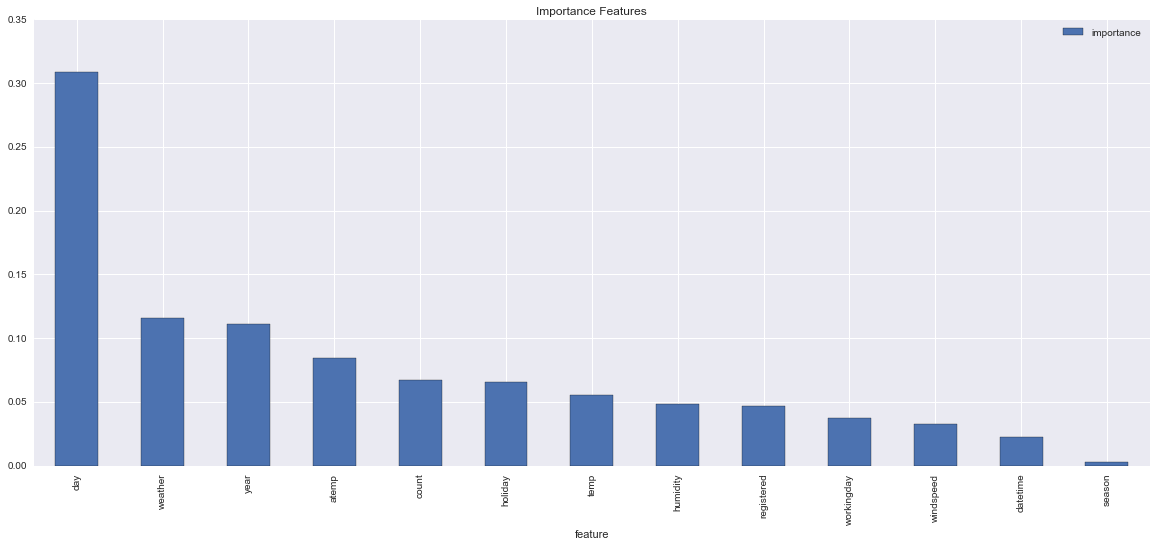

In [12]:
model = xgb.XGBRegressor()
print('xgboost', log_registered_casual_prediction(train, model))
draw_importance_features(model, train)

## What about a bit magic feature engineering? :)

('xgboost', 0.34919888465050125)


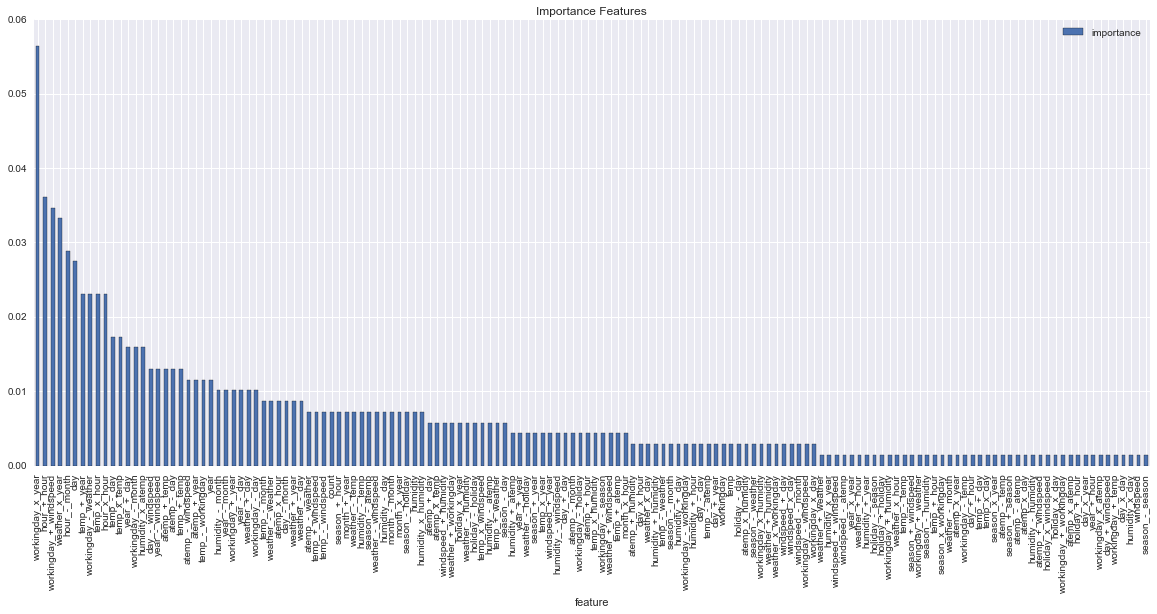

In [13]:
import itertools

def get_num_features(data):
    columns = data.loc[ :, (data.dtypes == np.float) |  (data.dtypes == np.int64) ].columns.values
    
    return [c for c in columns if 'count' not in c and 'registered' not in c and 'casual' not in c]

def generate_new_features(data):
    num_cols = get_num_features(data)
    for feat_x, feat_y in itertools.product(num_cols, num_cols):
        name_times = '{0}_x_{1}'.format(feat_x, feat_y)
        name_plus  = '{0}_+_{1}'.format(feat_x, feat_y)
        name_diff  = '{0}_-_{1}'.format(feat_x, feat_y)

        data[name_times] =  data[feat_x] * data[feat_y]
        data[name_plus]  =  data[feat_x] + data[feat_y]
        data[name_diff]  =  data[feat_x] - data[feat_y]
        

train_magic = train.copy()
generate_new_features(train_magic)

model = xgb.XGBRegressor()
print('xgboost', log_registered_casual_prediction(train_magic, model))
draw_importance_features(model, train_magic)

## Compare with other models
- DecisionTreeRegressor
- RandomForestRegressor
- ExtraTreesRegressor
- GradientBoostingRegressor
- AdaBoostRegressor
- BaggingRegressor

In [13]:
models = [
    ('decision_tree', DecisionTreeRegressor()),
##put here other algorithms (mentioned above)
    
]

for model in models:
    print(model[0], log_registered_casual_prediction(train, model[1]))


('decision_tree', 0.44508655314844409)


## Tuning hyperparameters

In [71]:
for max_depth in [2, 5, 10]:
    for n_estimators in [100, 200, 300]:
        params = {'max_depth': max_depth, 'n_estimators': n_estimators}
        model = xgb.XGBRegressor(**params)
        print(params, log_registered_casual_prediction(train, model))

({'n_estimators': 100, 'max_depth': 2}, 0.46000367817350141)
({'n_estimators': 200, 'max_depth': 2}, 0.383063126639346)
({'n_estimators': 300, 'max_depth': 2}, 0.36217291062931611)
({'n_estimators': 100, 'max_depth': 5}, 0.33877146331666108)
({'n_estimators': 200, 'max_depth': 5}, 0.3329926658794557)
({'n_estimators': 300, 'max_depth': 5}, 0.33179067955100161)
({'n_estimators': 100, 'max_depth': 10}, 0.33338905009262376)
({'n_estimators': 200, 'max_depth': 10}, 0.33411251538787728)
({'n_estimators': 300, 'max_depth': 10}, 0.33430611210836408)


let's try play around with subsample, learning_rate and ohers...

### What about tuning training_magic dataset? One example possible values...

In [35]:
params = {
    'max_depth': 6, 
    'n_estimators': 600, 
    'subsample': 0.95, 
    'colsample_bytree': 0.3, 
    'learning_rate': 0.05, 
    'reg_alpha': 0.1
}
model = xgb.XGBRegressor(**params)
print(params, log_registered_casual_prediction(train_magic, model))

({'reg_alpha': 0.1, 'colsample_bytree': 0.3, 'learning_rate': 0.05, 'n_estimators': 600, 'subsample': 0.95, 'max_depth': 6}, 0.32089853387438022)


What about feature selection (remove all useless features)? Tips: `sklearn.feature_selection.*`